# Lotka Volterra Equation Using Neural ODE

In [167]:
import torch
import torch.nn as nn
import torchdyn
import numpy as np
#from neuralode import NeuralODE, NeuralODEModel
from torchdyn.numerics.odeint import odeint, _fixed_odeint, _adaptive_odeint
from torchdiffeq import odeint as ode
import matplotlib.pyplot as plt

In [168]:
# TODO : Lotka Volterra Equation Using Neural ODE of deepchem
# Solve LV eq using odesolver
# learn the dynamics using neural ode

In [169]:
alpha = 1. #mortality rate due to predators
beta = 1.
delta = 1.
gamma = 1.

x0 = torch.Tensor([4.])
y0 = torch.Tensor([2.])

def derivative(t, X, **kwargs):
    x, y = X 
    dotx = x * (alpha - beta * y)
    doty = y * (-delta + gamma * x)

    return torch.Tensor([dotx, doty])

In [170]:
Nt = 1000
tmax = 30.
t_span = torch.linspace(0.,tmax, Nt)

X0 = [x0, y0]
X0 = torch.Tensor(X0)

#res = integrate.odeint(derivative, X0, t, args = (alpha, beta, delta, gamma))
#print(X0.shape)
res = odeint(derivative, X0, t_span=t_span, solver='tsit5')


In [171]:
def series(res):
    t, X = res
    x,y = np.array([]), np.array([])
    
    #with torch.no_grad():
    
    for val in X:
                
        x = np.append(x,val[0])
        y = np.append(y,val[1])
    
    return x,y

x,y = series(res)


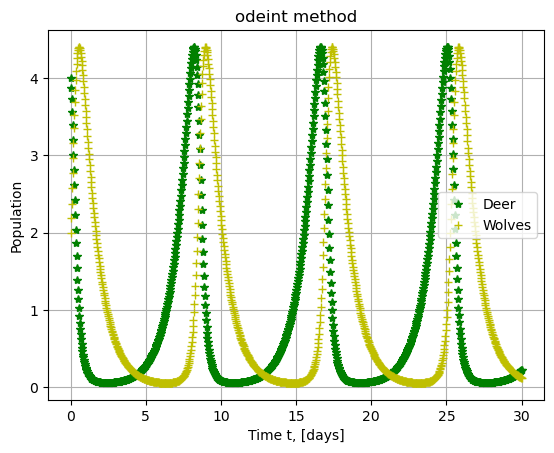

In [172]:
plt.figure()
plt.grid()
plt.title("odeint method")
plt.plot(t, x, '*g', label = 'Deer')
plt.plot(t, y, '+y', label = "Wolves")
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.legend()

plt.show()

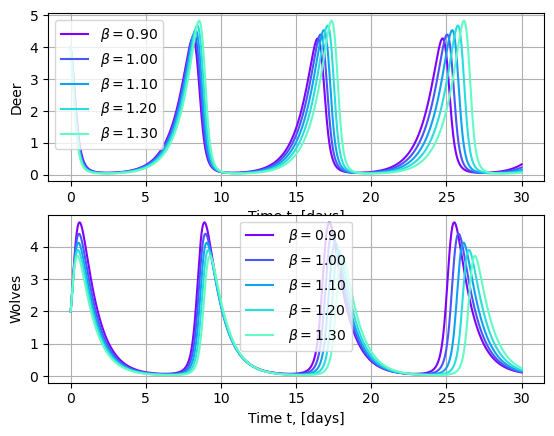

In [173]:
import random
import matplotlib.cm as cm


alpha = 1. #mortality rate due to predators
#beta = 1.
delta = 1.
gamma = 1.

betas = np.arange(0.9, 1.4, 0.1)

nums=np.random.random((10,len(betas)))
colors = cm.rainbow(np.linspace(0, 1, nums.shape[0]))  # generate the colors for each data set

fig, ax = plt.subplots(2,1)

for beta, i in zip(betas, range(len(betas))):
    res = odeint(derivative, X0, t, solver='tsit5')
    x,y = series(res)
    ax[0].plot(t, x, color = colors[i],  linestyle = '-', label = r"$\beta = $" + "{0:.2f}".format(beta))
    ax[1].plot(t, y, color = colors[i], linestyle = '-', label = r" $\beta = $" + "{0:.2f}".format(beta))
    ax[0].legend()
    ax[1].legend()

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Time t, [days]')
ax[0].set_ylabel('Deer')
ax[1].set_xlabel('Time t, [days]')
ax[1].set_ylabel('Wolves');

#### So far, we have known the dynamics of the system, i.e. it's equations ! For a general system we would not be given it's differential equation,
#### we might need to model the system from it's input and output only, in that case we can use a neural network as a vector field of the ODE, and train
#### the system on a set of input and output of a system

In [174]:
import torch
import torch.nn as nn

import numpy as np
import torchdyn


import tqdm

## Given initial conditions, predict the predator and prey population at given point of time

In [185]:
class LotkaVolterraDataset(torch.utils.data.Dataset):

    def __init__(self, X):
        self.t, X = X
        
        self.x, self.y = np.array([]), np.array([])

        for val in X:        
            self.x = np.append(self.x, val[0])
            self.y = np.append(self.y, val[1])
        

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        return self.t[idx], self.x[idx], self.y[idx]

res = odeint(derivative, X0, t_span, solver='tsit5')
dataset = LotkaVolterraDataset(res)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1000)
data_iter = iter(train_loader)


In [176]:
p = data_iter.next()

In [177]:
print(p[2].dtype)

torch.float64


In [178]:
class f(nn.Module):
  def __init__(self, dim):
    super(f, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(dim,124),
        nn.ReLU(),
        nn.Linear(124,124),
        nn.ReLU(),
        nn.Linear(124,dim),
        nn.Tanh()
    )

  def forward(self, t, x):
    x = x.float()
    return self.model(x)

from torchdyn.core import NeuralODE

class DifferentialEquation(nn.Module):
  
  def __init__(self, 
               network:nn.Module = f(dim=1000), 
               t_span=torch.Tensor([0., 1.]), 
               solver='tsit5', 
               order=1, 
               atol=0.001, 
               rtol=0.001,
               sensitivity='autograd', 
               atol_adjoint=0.0001, 
               rtol_adjoint=0.0001, 
               interpolator = None, 
               integral_loss=None, 
               seminorm=False, 
               return_t_eval=True, 
               optimizable_params={}) -> None:

    super(DifferentialEquation, self).__init__()
    
    #self.input_layer = nn.Linear(1000,124)
    self.model = NeuralODE(vector_field=network, 
                  solver=solver, 
                  order=order, 
                  atol=atol, 
                  rtol=rtol, 
                  sensitivity=sensitivity, 
                  atol_adjoint=atol_adjoint, 
                  rtol_adjoint=rtol_adjoint, 
                  interpolator=interpolator, 
                  integral_loss=integral_loss, 
                  seminorm=seminorm, 
                  return_t_eval=return_t_eval, 
                  optimizable_params=optimizable_params)
    #self.output_layer = nn.Linear(124,1000)

    self.t_span = t_span
    
  def forward(self, t):
    z = self.model(t, self.t_span)
    
    return x

In [179]:
Nt = 1000
tmax = 30.
t_span = torch.linspace(0.,tmax, Nt).float()
predator = DifferentialEquation(f(dim=1000), t_span = t_span)
prey = DifferentialEquation(f(dim=1000), t_span = t_span)


In [180]:
t, x, y = p
x1 = predator(t)
y1 = prey(t)


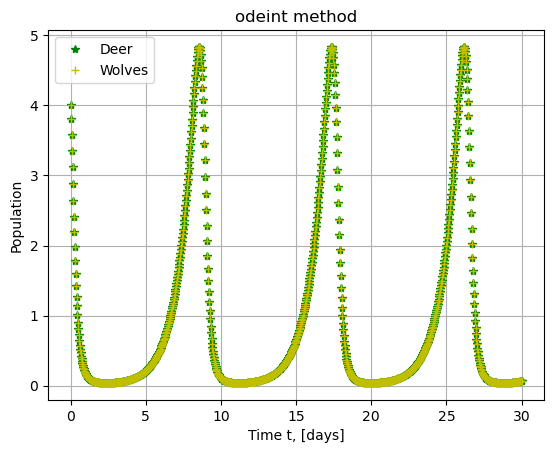

In [181]:

plt.figure()
plt.grid()
plt.title("odeint method")
plt.plot(t, x1, '*g', label = 'Deer')
plt.plot(t, y1, '+y', label = "Wolves")
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.legend()

plt.show()


In [186]:
N_EPOCH = 10
optimizer_predator = torch.optim.Adam(predator.parameters(), lr=0.005)
optimizer_prey = torch.optim.SGD(prey.parameters(), lr=0.002)

lossFn = nn.CrossEntropyLoss()

running_loss = 0.0

data_iter = iter(train_loader)

for epoch in tqdm.tqdm(range(N_EPOCH)):
    x_train, y_train, t_train = data_iter.next()
    x_train.requires_grad = True
    y_train.requires_grad = True
    x_out = predator(t_train)
    y_out = prey(t_train)

    loss_predator = lossFn(x_out, x_train)
    loss_prey = lossFn(y_out, y_train)

    optimizer_predator.zero_grad()
    optimizer_prey.zero_grad()

    loss_predator.backward()
    loss_prey.backward()

    optimizer_predator.step()
    optimizer_prey.step()

    running_loss += loss_predator
    running_loss += loss_prey

    
    

 10%|█         | 1/10 [00:07<01:09,  7.74s/it]


StopIteration: 